# Linear model 
Tobias C. Haase \
Master's student of Psychology at [Goethe-University Frankfurt](https://www.goethe-university-frankfurt.de/en?locale=en)


Dataset: [Abrupt hippocampal remapping signals resolution of memory interference](https://openneuro.org/datasets/ds003707/versions/1.0.0)


Within the data exploration notebook, I outlined some information regarding the task design, the functional and structural data. This notebook will contain the development of the linear model as well as the results. 

Within the folder "preprocessing attempts" various attempts to preprocess the data are outlined. Preprocessing on my own device failed, thankfully I was able to preprocess most participants via [brainlife](https://brainlife.io/).

These are the preprocessing and quality control pipelines used:

Quality controle was performed using the [Magnetic Resoncance Imaging Quality Controle pipeline](https://mriqc.readthedocs.io/en/latest/) (22.0.6). 

The preprocessing was performed using [fMRI-Prep](https://fmriprep.org/en/stable/) (20.2.3)



Fistly I will load a preprocessed image. Then, going from the previously explored event files, I will briefly mention the experimental paradigm again. These will then be used for a generalized linear model (GLM).

I will first do the linear model for subject 6 to see if everything works (this subject was used as an example as it was the first participant with data for all runs).  

In [1]:
#Import of things I need later:
import os
import numpy as np
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain
import warnings

In [2]:
#File paths
file_path = "/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data"
fmri_img_run1_sub06_path = os.path.join(file_path, "outputs/fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-preproc_bold.nii.gz")
anat__img_run1_sub06_path = os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-preproc_T1w.nii.gz")

I have now the file paths to the mri images. Now I still need the event files to define respective contrasts. 


In [3]:
events_run1_sub06_path = os.path.join(file_path,"ds003707", "sub-06", "func", "sub-06_task-scene_run-01_events.tsv")

import pandas as pd
events_run1_sub06 = pd.read_table(events_run1_sub06_path)

events_run1_sub06

,onset,duration,correct,trial_type,response_time
0,10,4,0.0,1_A9,NaN
1,14,4,1.0,1_A2,1.486898
2,18,4,1.0,1_A1,0.752162
3,22,4,1.0,1_B4,0.334689
4,26,4,1.0,1_B0,0.368064
...,...,...,...,...,...
73,324,4,0.0,2_B16,NaN
74,328,4,1.0,foil05,0.735685
75,332,4,1.0,2_A17,0.534958
76,336,4,1.0,foil03,0.785550


In [4]:
events_run1_sub06 = events_run1_sub06[["onset", "duration", "trial_type"]]
for i, row in events_run1_sub06.iterrows():
    events_run1_sub06["trial_type"][i] = events_run1_sub06["trial_type"][i].replace('1_', 'Learned_')
    events_run1_sub06["trial_type"][i] = events_run1_sub06["trial_type"][i].replace('2_', 'Learned_')
    
warnings.filterwarnings('ignore')

/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

Each trial has a certain onset, the same duration and then the response is either correct or not correct. 
We also see that there is a certain response time - if this is failed the trial is listed to be `0.0` i.e. not correct. 


Now, lets generate a design matrix with these event files. Recall that a 'design matrix' is a matrix that contains the explanatory variables. Here, the explanatory variables also involes the regressors that are the result of the previously mentioned pipelines!

First, before I can generate a `FirstLevelModel`, I need to extract the repetion time.

In [5]:
from nilearn.glm.first_level import FirstLevelModel

#Now I need the TR and other parameters. I previously extracted them using the 'pybids module! Here I will take also show a different attempt:

import nibabel as nib ;

fmri_img_run1_sub06 = nib.load(fmri_img_run1_sub06_path);
#The get_zooms function contains voxel size with the 4th entry being the time, this is therefore the repetiton time!
fmri_img_run1_sub06.header.get_zooms()[3]

2.0

Knowing the repition time, we can set up the `FirstLevelModel`.

Briefly explained, I understand a first level model as a first step used to generate the linear models later - there are certain things like the haemondynamic response that needs to be modelled, which will be done in this first step!

Here is an explanation on the parameters:
- `T_r` refers to the repetion time, this was extracted above. 
- `Drift mode`: It's a `cosine functio` that aims to remove effects of heart rate etc. The standard setting here is 1/128 Hz. In the design matrix this will end up as a column with almost no change in color, only very slight drift!
- The `hrf-model` part specifies the`hemodynamic response model`: The event file has certain events, but this needs to be converted into a ["reference BOLD signal for the design matrix"](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html). Here the basic wasn't choosen, but the `spm`. This stands for statistical parametric map. In contrast to the basic the undershoot following the haemondynamic response is said to be weaker here.
- Fruthermore, a `high pass filter` can be applied. The high pass filter will let [higher frequencies pass](https://www.brainvoyager.com/bv/doc/UsersGuide/Preprocessing/TemporalHighPassFiltering.html), the cut-off here is set to another value than the standard! What does this mean? I will have an additional confound with the lower frequencies, them being included in the model instead of them being removed!
&nbsp;


- `noise_model`: There are different options for noise models. The `ar1` is the preset noise model. A ordinary least squared approach, autoregressive approaches of higher order or other models could have been used. 
&nbsp;


- I don't want the signal to be scaled, so this is set to false!

In [6]:
fmri_glm = FirstLevelModel(t_r=2.0,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./128,
                           signal_scaling=False,
                           minimize_memory =  False)

This model still lacks the confounds.

In [7]:
import pandas as pd
import numpy as np
confounds_run1_sub06 = pd.read_csv(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-confounds.tsv"), 
                                  delimiter = '\t')
#The delimiter needs to be set to \t as it uses tab to differentiate different entries. 

column_names = list(confounds_run1_sub06.columns.values)
column_names

['global_signal',
 'global_signal_derivative1',
 'global_signal_power2',
 'global_signal_derivative1_power2',
 'csf',
 'csf_derivative1',
 'csf_derivative1_power2',
 'csf_power2',
 'white_matter',
 'white_matter_derivative1',
 'white_matter_power2',
 'white_matter_derivative1_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'framewise_displacement',
 'rmsd',
 't_comp_cor_00',
 't_comp_cor_01',
 't_comp_cor_02',
 't_comp_cor_03',
 't_comp_cor_04',
 't_comp_cor_05',
 't_comp_cor_06',
 't_comp_cor_07',
 't_comp_cor_08',
 't_comp_cor_09',
 't_comp_cor_10',
 't_comp_cor_11',
 't_comp_cor_12',
 't_comp_cor_13',
 'a_comp_cor_00',
 'a_comp_cor_01',
 'a_comp_cor_02',
 'a_comp_cor_03',
 'a_comp_cor_04',
 'a_comp_cor_05',
 'a_comp_cor_06',
 'a_comp_cor_07',
 'a_comp_cor_08',
 'a_comp_cor_09',
 'a_comp_cor_10',
 'a_comp_cor_11',
 'a_comp_cor_12',
 'a_comp_cor_13',
 'a_comp_cor_14',
 'a_comp_cor_15',
 'a_comp_cor_16',
 'a_comp_cor_17',
 'a_comp_cor_18',
 'a_comp_cor_19',
 'a_comp_cor_20',


Only a portion of the entries are needed here. 

The following are extracted, following the recommedation from the [fmriprep-doc](https://fmriprep.org/en/stable/outputs.html#confounds). 
- The parameters of head motion, i.e. the transverse and rotational movements. `trans_x`, `trans_y`, `trans_z`, `rot_x`, `rot_y`, `rot_z`.

&nbsp;
The following three are copy-pastad from said website:
- `csf - the average signal within anatomically-derived eroded CSF mask`
- `white_matter - the average signal within the anatomically-derived eroded WM masks`
-  `global_signal - the average signal within the brain mask`

- the rmsd - this also takes head motion into account but using a different statistical approach.
- framewise_displacement - another classic measure of movement. 

As a high-pass filter is included, I will not include regressors for signal drift. 

In [8]:
confounds_glm_run1_sub06 = confounds_run1_sub06[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
confounds_glm_run1_sub06

,white_matter,global_signal,framewise_displacement,csf,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,rmsd
0,5975.756217,6126.668641,0.000000,10444.063602,0.034271,-0.011028,0.033954,-9.374490e-05,-0.000297,0.000453,0.000000
1,5978.942933,6126.743570,0.025447,10346.109765,0.027841,-0.012104,0.039323,-1.323490e-23,-0.000346,0.000343,0.011883
2,5980.483029,6132.032324,0.033753,10362.884937,0.033482,-0.003517,0.024437,0.000000e+00,-0.000337,0.000259,0.018279
3,5978.650057,6129.665218,0.036861,10217.434957,0.028032,0.007799,0.031598,-1.201740e-04,-0.000375,0.000158,0.017710
4,5976.735798,6126.883741,0.042074,10232.444192,0.025611,-0.012633,0.035864,-2.646980e-23,-0.000372,0.000334,0.023282
...,...,...,...,...,...,...,...,...,...,...,...
172,5967.351326,6132.775404,0.052491,10434.865707,-0.027287,0.028218,-0.022084,-1.446660e-04,-0.001686,-0.000312,0.027091
173,5968.436398,6133.940994,0.070713,10374.021769,-0.025793,0.058979,-0.031075,-5.428840e-04,-0.001758,-0.000193,0.038925
174,5971.929799,6125.377610,0.017491,10288.476298,-0.022662,0.057221,-0.036650,-5.242960e-04,-0.001830,-0.000142,0.008184
175,5971.281566,6122.549079,0.064655,10343.196182,-0.020640,0.030443,-0.018628,-3.507080e-04,-0.001647,-0.000142,0.034101


I have now specified the confounds I will need. 


Below, there is one step that only works with never versions of nilearn (0.9.2. and newer) but is not necessary here. The event files only start after 5 volumes, meaining with a repetition time of 2 after 10 seconds. 
A sample mask can be used to remove them, which is an option I am not going to do to make it easier to analyse a lot of files later fast and thus remove one unnecessary analyses steps. 

In [9]:
import nilearn.image as nli

#Loading the image to get the amount of volumes.
sub06_run1_bold = nli.load_img(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-preproc_bold.nii.gz"))
sub06_run1_bold_mask = np.arange((sub06_run1_bold.get_fdata().shape[3]))[5:]  
#creating an array with the amount entries equaling volumes except the first 10 seconds / 5 volumes. 
# just another way besides looking at the .json! Although a one with longer loading times!
sub06_run1_bold_mask

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176])

Now lets run the model!

In [10]:
fmri_glm_run1_sub06 = fmri_glm.fit(fmri_img_run1_sub06_path, events = events_run1_sub06, \
                                          # sample_masks = sub06_run1_bold_mask, \ removed
                                          confounds = confounds_glm_run1_sub06)

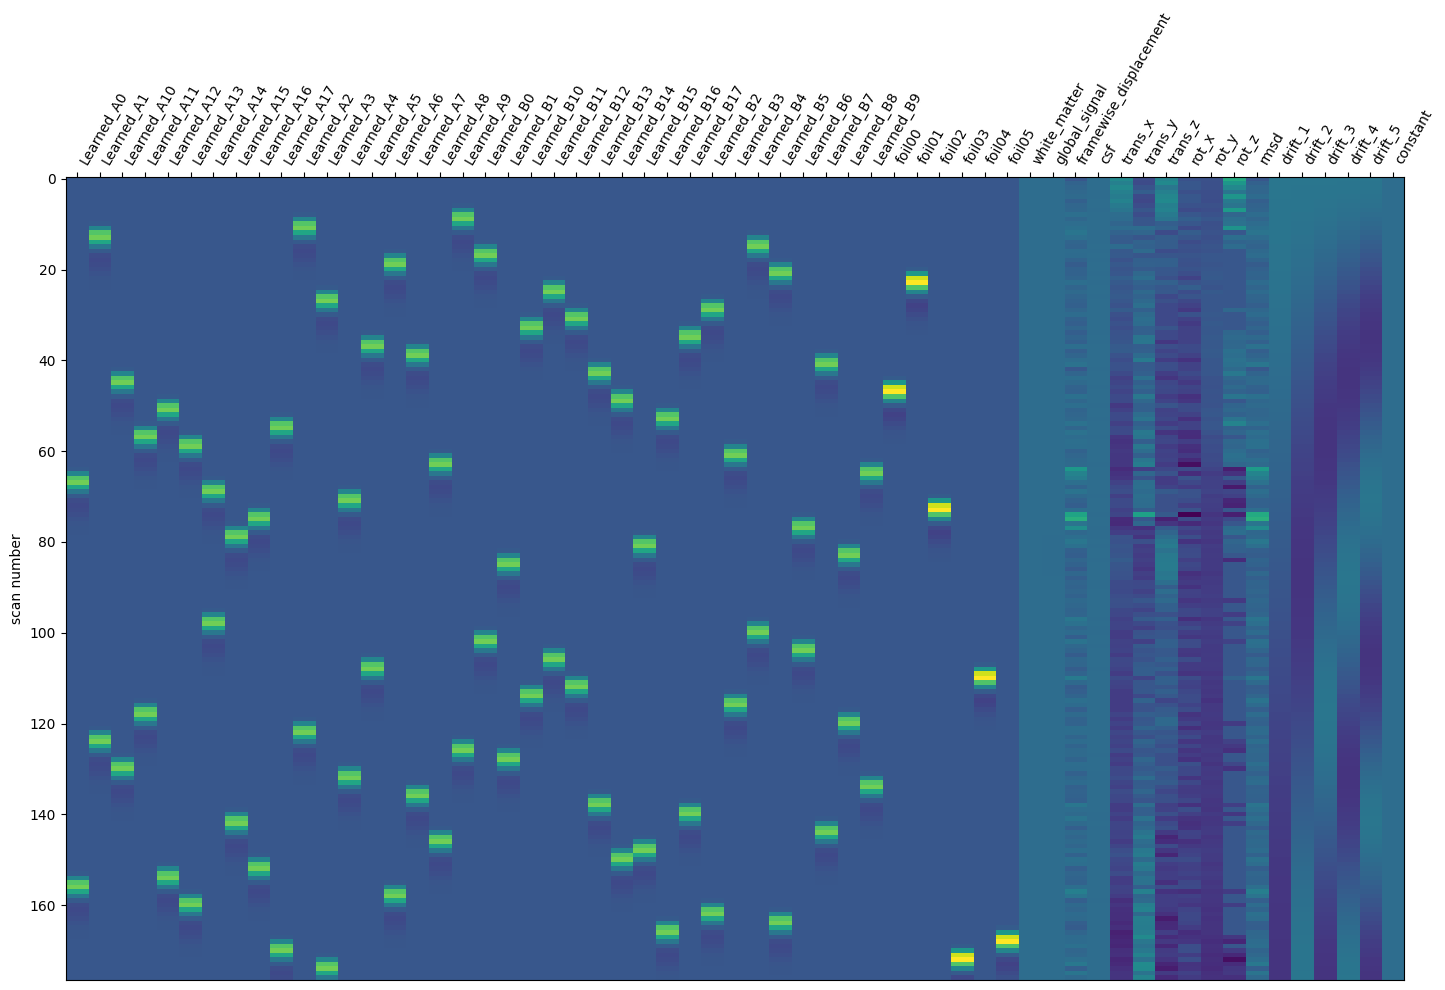

In [11]:
design_matrix = fmri_glm_run1_sub06.design_matrices_[0]

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

There was 36 objects or scenes. Each was repeated twice per run. There were 18 object scene pairmates as explained in the data exploration. 

Let's save this design matrix!

In [12]:
outdir = 'results'
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/")

if not os.path.exists(outdir):
    os.mkdir(outdir)


from os.path import join
plot_design_matrix(design_matrix, output_file=join(outdir, 'design_matrix.png'))

outdir_path = os.path.join(file_path, "outputs", "results")

I am already creating an output folder for participant 6.

In [23]:
if not os.path.exists(os.path.join(outdir_path, "sub-06")):
    os.mkdir(os.path.join(outdir_path, "sub-06"))
else: 
    print("This one already exists!")

This one already exists!


To ensure this works, I want to inspect the expected response for a random item. 

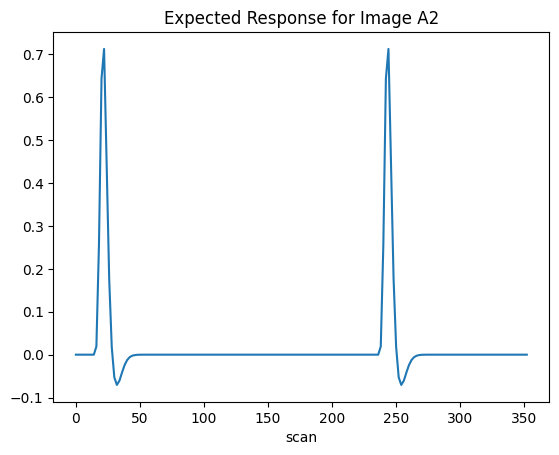

In [20]:
plt.plot(design_matrix['Learned_A2']) 
plt.xlabel('scan')
plt.title('Expected Response for Image A2')
plt.show()

Thus far everything seems to work as intended. 

Now I want to identify voxels that have significant effects within the next section.

### Detection of Significant Voxels

Firstly, I will need to get the betas for every voxel. To achieve this, I need to first get the contrasts. These will require some data wrangling, which will be done in the following. 

In [24]:
from numpy import array
array_learned = np.array([0]*design_matrix.shape[0])
                            
conditions = {
    'active - Learned': np.array([0]*design_matrix.shape[1]),
    'active - Foil':   np.array([0]*design_matrix.shape[1]),
}

In [25]:
i = 0
for col in design_matrix:
    if "foil" in col:     #Creating the contrast for the lure images. 
        conditions['active - Foil'][i] = 1
    elif "Learned_A" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    elif "Learned_B" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    i = i+1   

In [26]:
conditions

{'active - Learned': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'active - Foil': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

Let's have a look at the conditions and see if it worked.

In [27]:
conditions

{'active - Learned': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'active - Foil': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

Above, I have created some first contrasts to test the rest of the glm. If this works, I may change it according to what I wanted to do initially!

Here is the contrast for the learned images:

<AxesSubplot:label='conditions'>

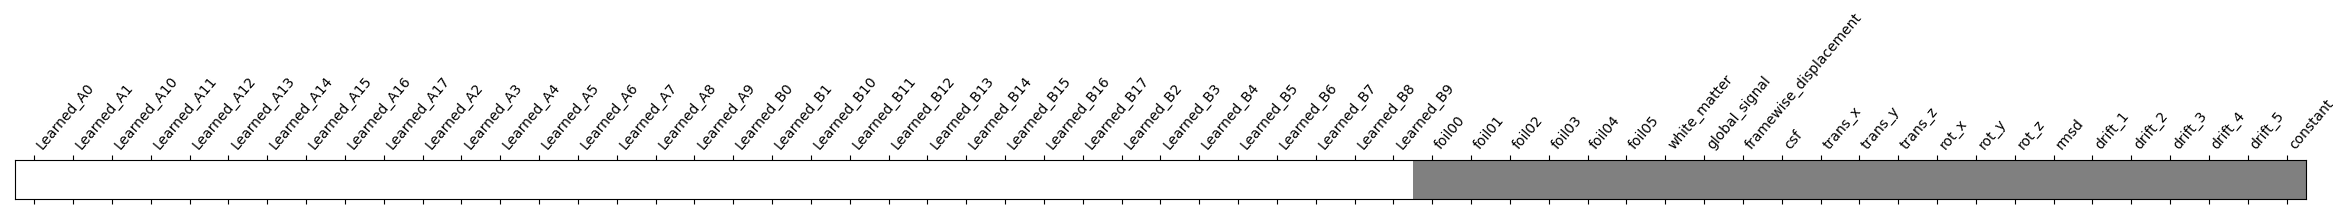

In [28]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Learned'], design_matrix=design_matrix)

Here is the contrast for the lures. 

<AxesSubplot:label='conditions'>

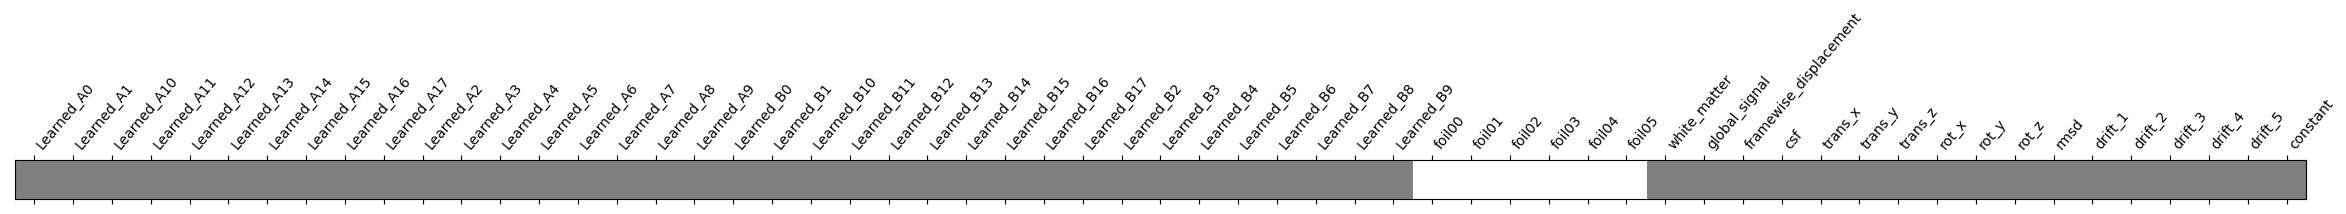

In [29]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Foil'], design_matrix=design_matrix)

The contrast I would like to take is the learned images vs the foils. The contrasts are therefore:

<AxesSubplot:label='conditions'>

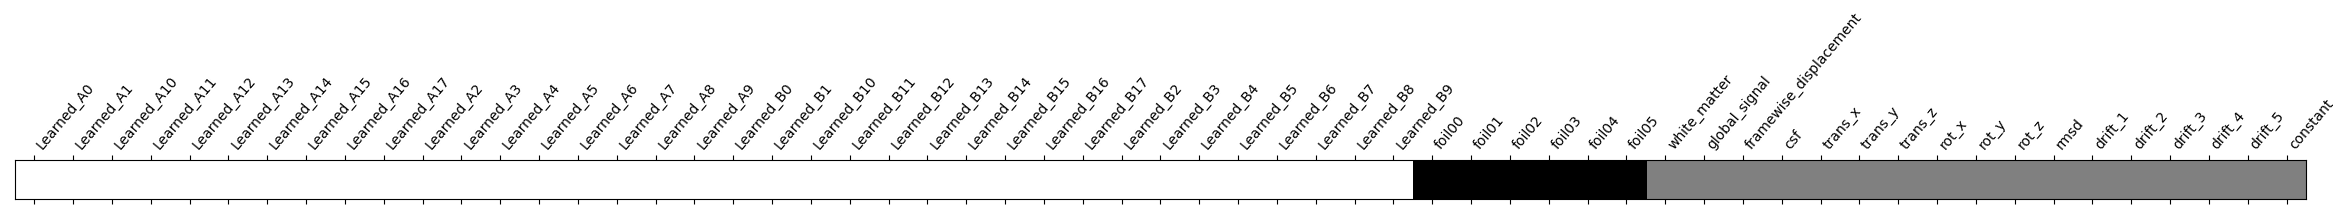

In [30]:
active_learned_vs_foil = conditions['active - Learned'] - conditions['active - Foil']
plot_contrast_matrix(active_learned_vs_foil, design_matrix=design_matrix)

In [31]:
eff_map = fmri_glm_run1_sub06.compute_contrast(active_learned_vs_foil,
                                    output_type='effect_size')

This shows the estimated effects without involving any corrections for the variation. 

The next plot contains the z-map. Here, we use z scores that are approximated by t-values. As mentioned before, the functional image is cut off. The treshold is choosen arbitraily following the preset value in nilearn's example.

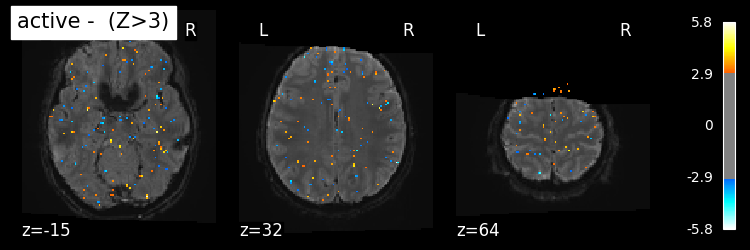

In [32]:
z_map_sub06_run1 = fmri_glm_run1_sub06.compute_contrast(active_learned_vs_foil,
                                  output_type='z_score')

#Get the mean image
from nilearn.image import mean_img
mean_img_run1_sub06 = mean_img(fmri_img_run1_sub06_path)

plot_stat_map(z_map_sub06_run1, bg_img=mean_img_run1_sub06, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active -  (Z>3)')
plt.show()

This is the z-map with a treshold of the false-discovery rate: It's set to 0.001 for all the significant voxels together. This is what's meant by `fpr`, it stands for the control for the false recovery rate. 

Uncorrected p<0.001 threshold: 3.291


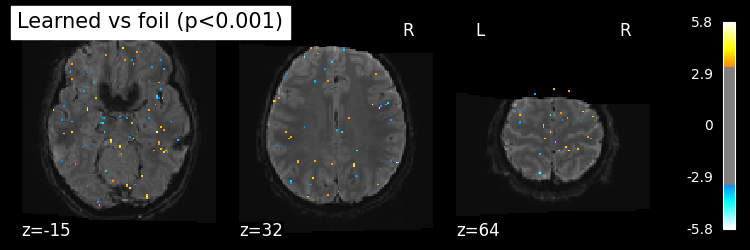

In [33]:
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(z_map_sub06_run1, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map_sub06_run1, bg_img=mean_img_run1_sub06, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,title= 'Learned vs foil (p<0.001)')
plt.show()

And here I correct for multiple comperison. The family wise error is corrected using the Bonferroni-correction. 

Bonferroni-corrected, p<0.05 threshold: 5.254


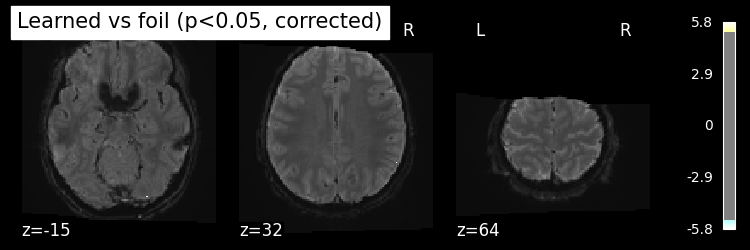

In [34]:
_, threshold = threshold_stats_img(
    z_map_sub06_run1, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map_sub06_run1, bg_img=mean_img_run1_sub06, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Learned vs foil (p<0.05, corrected)')
plt.show()

Having displayed the different options, I am going for the following:
  - I am interested in smaller clusters, for example within the hippocampus. I will therefore choose a smaller cluster treshold. \
      &rarr; Furthermore, FDR-correction should, correct for the increase in voxels with no exclusion of smaller clusters.     
    
  - I do want to correct for the multiple comparisons, as a trade-off between being rather conservative (Bonferonni) and a rather liberal approach (controlling for the false-positive rate), I want to control for the proportion of false discoveries among the deteced values. 
  
The correction for the false discovery rate controls for the the number of false positives among the subset of voxels that are significant (Genovese, 2002). 

False Discovery rate = 0.001 threshold: 3.291


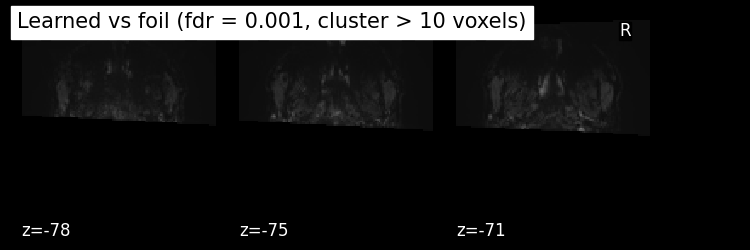

In [35]:
clean_map, threshold = threshold_stats_img(z_map_sub06_run1, alpha=.001, height_control='fpr', cluster_threshold= 10)
print('False Discovery rate = 0.001 threshold: %.3f' % threshold)
plot_stat_map(clean_map, bg_img=mean_img_run1_sub06, threshold = threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Learned vs foil (fdr = 0.001, cluster > 10 voxels)')
plt.show()

#Saving the z-map for future use:
z_map_sub06_run1.to_filename(os.path.join(outdir, 'sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz'))


Let's extract any significant voxels from the above image and look at them. 

In [36]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map_sub06_run1, stat_threshold=threshold,
                           cluster_threshold=10)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


As seen above, with the conservative approach with the family-wise error correction, there is no cluster that appears significant (at least with the treshold set right now). I will need to see if there are any errors above etc. 

Non of the clusters are significant - but with the following bit I could get more information on them. 

In [37]:
from atlasreader import create_output
create_output(os.path.join(outdir, "sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz"),
              cluster_extent=10, voxel_thresh=threshold)

            #With the zmap, the previously defined treshold and the zmap, this function creates multiple files that
            #allow to explore the exploration of the z-map. 
            

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



The peak is the value in each cluster with the highest signal value, as well as information regarding this peak.

In [38]:
peak_info_sub_06_run_1 = pd.read_csv(os.path.join(outdir, "sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap_peaks.csv"))

peak_info_sub_06_run_1

FileNotFoundError: [Errno 2] No such file or directory: 'results/sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap_peaks.csv'

Let's visualize this:

In [ ]:
from IPython.display import Image
Image(os.path.join(outdir, "sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.png"))

Having explored this all in detail, let's take the short-cut of just using the glm report function and see what this function comes up with. I will later use the report via the BIDS structure which nilearn also entails. 

In [ ]:
from nilearn.reporting import make_glm_report

report = make_glm_report(fmri_glm_run1_sub06, contrasts= active_learned_vs_foil,
                         bg_img=mean_img_run1_sub06)

Let's lastly look at the R-squared to see how much variance is explained. The R² is baded on the glm. 

In [ ]:
from nilearn import plotting
plotting.plot_stat_map(fmri_glm_run1_sub06.r_square[0], bg_img=mean_img_run1_sub06, threshold=.1,
                       display_mode='z', cut_coords=7, cmap='magma');

## Extending the GLM to the Other Runs

Before I can incorporate the other runs, I need to decide on how to crossvalidate. 
The stimuli are the same across runs and across people. There are two options:
1. Use a certain number of runs and cross-validate by using runs from every participants. 
2. Use a certain amount of participants to cross-validate. 

As at the moment of making this decision, it is uncertain how many people will actually be fully preprocessed, I am deciding to cross-validate by using a few runs per person. It seems like a 4 to 2 split would be justified. 

First I am loading all fmri-images and I am concatenating them. This first step will generate a list with all file paths for one participant. 

In [53]:
import os 
fmri_img_sub06 = []
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-06/")
for i in os.listdir():
    file_name = i
    if file_name.endswith("bold.nii.gz") and "scene" in file_name: 
         fmri_img_sub06.append(file_name)
    else:
         continue

Now, I have all the image paths. But the actual images still need to be attached to each other! This way, the confunds that do not change acrosss the runs can be modelled as continous. The loop below still does not incorporate this and I will need to do so in the near future. 


In [18]:
file_path = "/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data"
for subject in ['03']:
    print("Now calculating %s" % subject)
    for run in ['01', '03', '04', '05', '06', '07']:
        print("For %s, now calculating run %s" %(subject, run))
        #Setting the paths
        fmri_img_path = os.path.join(file_path, "outputs/fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-preproc_bold.nii.gz" %(subject, run))
        anat__img_path = os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-preproc_T1w.nii.gz" %(subject, run))
    
        # read in the events
        events = pd.read_table(os.path.join(file_path,"ds003707", "sub-%s" %(subject), "func", "sub-%s_task-scene_run-%s_events.tsv" %(subject, run)))
    
        #perform operations on the events table to make it fit the glm
        events = events[["onset", "duration", "trial_type"]]
        for i, row in events.iterrows():
            events["trial_type"][i] = events["trial_type"][i].replace('1_', 'Learned_')
            events["trial_type"][i] = events["trial_type"][i].replace('2_', 'Learned_')
    
        # read in the confounds
        confounds = pd.read_csv(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-confounds.tsv" %(subject, run)), 
                                  delimiter = '\t')
    
        # restrict the to be included confounds to a subset
        confounds_glm = confounds[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
    
        # run the GLM
        fmri_glm = fmri_glm.fit(fmri_img_path, events, confounds_glm)
    
        # compute the contrast as a z-map
        z_map = fmri_glm.compute_contrast(active_learned_vs_foil,
                                  output_type='z_score')
        
        #defining the folder, where the resulting zmap shall be stored. To make it more easily manually inspectable, a folder for each participant is created
        if not os.path.exists(os.path.join(outdir_path, "sub-%s" %subject)):
            os.mkdir(os.path.join(outdir_path, "sub-%s" %subject))
        
        # save the z-map
        z_map.to_filename(os.path.join(outdir_path, "sub-%s" %test, 'sub-%s_task-scene_run-%s_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz' %(subject, run)))

Now calculating 03
For 03, now calculating run 01


NameError: name 'active_learned_vs_foil' is not defined

In [75]:
complete_subjects = ['03', '05', '06', '08', '09', '10', '11', '12', '14', '19', '20', '22', '23', '24', '25', '27','28', '34', '35', '36']

![tobecontinued](https://media.giphy.com/media/W9wHF6yVazlrW/giphy.gif)

In [17]:
os.path.join(

'/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-06'